In [1]:
!pip install plotly
!pip install confluent-kafka

     |████████████████████████████████| 26.5 MB 809 kB/s eta 0:00:01    |█                               | 808 kB 809 kB/s eta 0:00:32
     |████████████████████████████████| 2.8 MB 932 kB/s eta 0:00:01


In [2]:
#imports
#Essentials
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import os

#Spark
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import *


from confluent_kafka import Producer
from confluent_kafka import Consumer
from pyspark import SparkContext
from pyspark.streaming import StreamingContext 
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window



# Data Analysis

In [3]:
#read csv files and present their shapes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_ID = test['Id']

### Train Dataset

In [4]:
print('Train shape :',train.shape)
train.head()

Train shape : (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Text(0.5, 1.0, 'Mssing Values Ratio - Train Data')

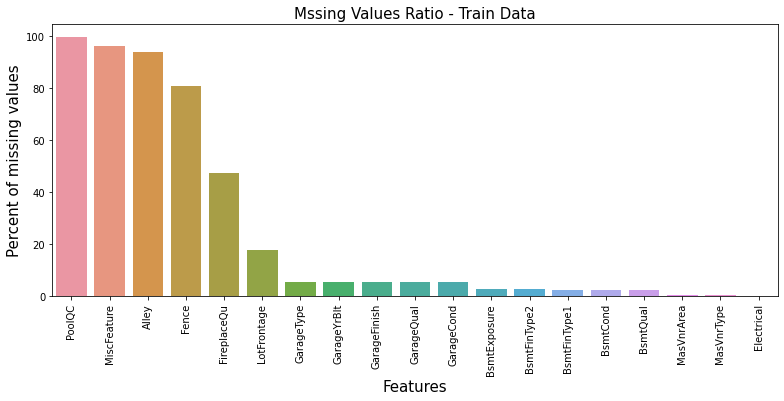

In [5]:
#calculate the missing value ratio of each feature
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]

#plot 
f, ax = plt.subplots(figsize=(13, 5))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Mssing Values Ratio - Train Data', fontsize=15)

The train set is with 1460 entries and 81 features, (include the SalePrice featrue).
We see there are many missing values that we need to fill or drop some features or maybe combine them.

### Test Dataset

In [6]:
print('Test shape :',test.shape)
test.head()

Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Text(0.5, 1.0, 'Mssing Values Ratio - Test Data')

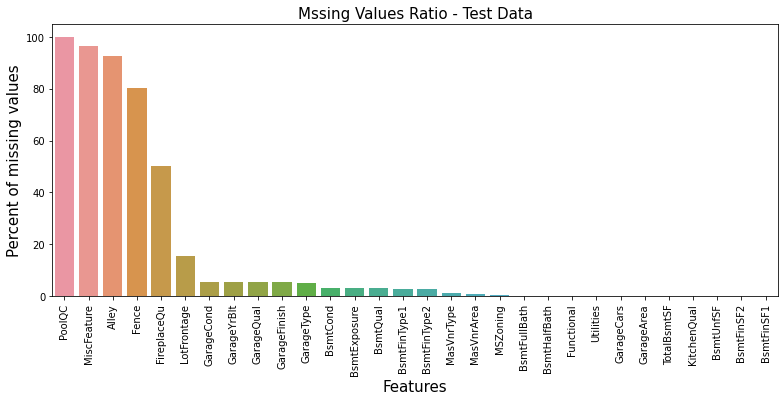

In [7]:
#calculate the missing value ratio of each feature
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)[:30]

#plot 
f, ax = plt.subplots(figsize=(13, 5))
plt.xticks(rotation='90')
sns.barplot(x=test_na.index, y=test_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Mssing Values Ratio - Test Data', fontsize=15)

### Explore 'SalePrice' feature
'SalePrice' feature is our target, the value that we want to predict.
We need to explore this feature to know it better and how it works, which features have an influence on it.

/home/linuxu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


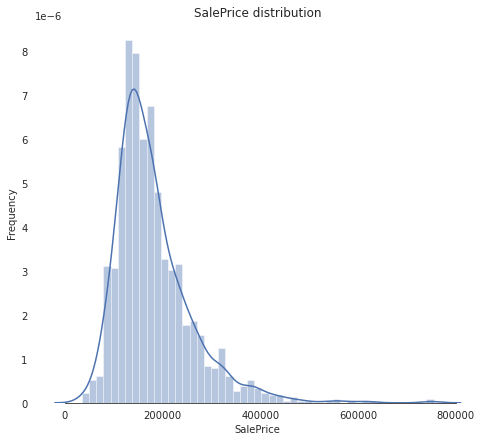

In [8]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [9]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


![](https://www.safaribooksonline.com/library/view/clojure-for-data/9781784397180/graphics/7180OS_01_180.jpg)

The 'SalePrice' graph has positive skew, which means there is derived from the normal distribution to the left side, which is means there are houses that are more sold at prices between 100K to 300K. Another thing is the skew, which tells us how much the tails of the graph are flattened, or for normal people - how the 'SalePrice' has more different values.



# Correlation matrix
Correlation can give us huge inforamtion about how the features impact on 'SalePrice' , let's check it out.
We got a lot of features and we want to select the features with high correlation with 'SalePrice' feature.

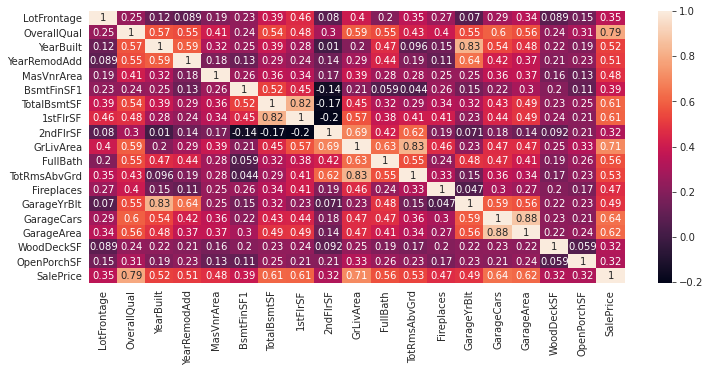

In [10]:
#Coralation plot
corr = train.drop('Id',axis=1).corr().abs()
top_feature = corr.index[corr['SalePrice']>0.3]
plt.subplots(figsize=(12, 5))
top_corr = train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

According to our heatmap, these are the variables most correlated with 'SalePrice'.
* OverallQual - It seems very intuitive, a house which is made with the best materials will cost more for sure.
* It seems that 'YearBuilt' is slightly correlated with 'SalePrice'.
* GrLiveArea it makes sense to high correlation with 'SalePrice', as big the living area as the price will be higher.
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. 'GarageCars' and 'GarageArea' are like the same.

Another higher correlation that isn't related to the target is TotRmsAbvGrd with GrLiveArea, which is very sensitive, and if the ground is larger so too the room nubmers.

## Pandas Profile EDA
We have a huge number of features and it's a bit messy. Exploring each of them alone with SalePrice will be too long and we will not reach the goal.
We will use Panda Profile to get a summary of the Data.


In [11]:
# import ProfileReport and show report of mushroom_df
#from pandas_profiling import ProfileReport
#ProfileReport(train, title="House Prices : Train Data", minimal=True)

In [12]:
train = spark.read.option("header",True)\
      .option("header", "true")\
      .option("inferschema", "true").csv('train.csv')
test = spark.read.option("header",True)\
      .option("header", "true")\
      .option("inferschema", "true").csv('test.csv')

# Missing values
As we can see, there are few features with a high missing value ratio. We need to do the distinguished between a categorical features or numeric features or ordinal features.



### Categorical filling NA
* PoolQC : data description says NA means "No Pool". That makes sense, given the huge ratio of missing value (+99%) and the majority of houses have no Pool at all in general. from the description we can see there is no value for NA (means it doesn't have Pool), so we need to assign a new value.

Same thing to all these features ;
* MiscFeature: data description says NA means "no miscMiscellaneous feature"
* Alley: data description says NA means "no alley access"
* Fence: data description says NA means "no fence"
* FireplaceQu: data description says NA means "no fireplace"
* Garage categorical features (GarageType,GarageFinish,GarageQual,GarageCond) 
* Basement categorical features (BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2)


same as the others that below, categorical feature with NA value that means it doesn't have none value and we can replace NA with new value.

In [13]:
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',):
    train = train.withColumn(col, regexp_replace(col, 'NA', 'None'))
    test = test.withColumn(col, regexp_replace(col, 'NA', 'None'))

for col in ('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):

    train = train.withColumn(col, regexp_replace(col, 'NA', 'None'))
    test = test.withColumn(col, regexp_replace(col, 'NA', 'None'))


* MasVnrType and MasVnrArea are comes togheter , and MasVnrType has a value with None (from description) so we can assume the missing values are None and MasVnrArea is 0.


In [14]:
train = train.withColumn('MasVnrType', regexp_replace('MasVnrType', 'NA', 'None'))
train = train.withColumn('MasVnrArea', regexp_replace('MasVnrArea', 'NA', '0'))

test = test.withColumn('MasVnrType', regexp_replace('MasVnrType', 'NA', 'None'))
test = test.withColumn('MasVnrArea', regexp_replace('MasVnrArea', 'NA', '0'))

We need a function to make random choice between values in categorical features.

In [15]:
def fill_na_random_pick_column_distribution(df, column_name):
    distinct_values = [row[0] for row in df.select(column_name).distinct().collect()]

    df = df.withColumn(column_name, regexp_replace(column_name, 'NA', str(np.random.choice(distinct_values))))
    return df

There are another type of missing values and they are categorical features too, but the NA doens't mean now that there isn't for DON'T HAVE value, and we need to make random choise to fill our NA values.

* Exterior1st - Exterior covering on house , one missing value.
* Exterior2nd - Exterior covering on house (if more than one material) , one missing value.

* BsmtFullBath and BsmtHalfBath shows us the basement bathroom, 2 missing value each.
* KitchenQual - Kitchen quality, we need to random choice from the different values, 1 missing value.
* Functional - Home functionality , 2 missing values.
* SaleType - Type of sale , 1 missing value.
* MSZoning - The general zoning classification
* Electrical - Electrical system , one missing value.


In [16]:
for col in ['Exterior1st','Exterior2nd','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','SaleType','MSZoning','Electrical']:
    train = fill_na_random_pick_column_distribution(train, col)
    test = fill_na_random_pick_column_distribution(test, col)

## Numeric filling NA
* LotFrontage: Linear feet of street connected to property, it has normal distrubition and I'm going to fill the NAs with median value.



In [17]:
train = train.withColumn("LotFrontage", train['LotFrontage'].cast('double'))
test = test.withColumn("LotFrontage", test['LotFrontage'].cast('double'))

In [18]:
imputer = Imputer(inputCols=['LotFrontage'],outputCols=['LotFrontage']).setStrategy("median")


In [19]:
train = imputer.fit(train).transform(train)
test = imputer.fit(test).transform(test)

The features BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF missing values are likely zero for having no basement.

In [20]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']:
    train = train.withColumn(col, regexp_replace(col, 'NA', 'None'))
    test = test.withColumn(col, regexp_replace(col, 'NA', 'None'))

GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
also the 'TotalBsmtSF' , if its value is 0 which means no basement.

In [21]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','TotalBsmtSF'):
    train = train.withColumn(col, regexp_replace(col, 'NA', '0'))
    test = test.withColumn(col, regexp_replace(col, 'NA', '0'))


## Drop features
* Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

* Street, same as Utilities - all records are "Pave" and only two for "Grvl", so it won't help in modelling.

In [22]:
train = train.drop('Utilities','Street','Id')
test = test.drop('Utilities','Street','Id')

## New features 

We see there is a lot combination of one feature that is splitted to other feature.
* TotalSF - Total square feet of the house.
* Total_Bathrooms - Sum the bathrooms.

In [23]:
#train
train = train.withColumn('TotalSF',train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF'])

train = train.withColumn('Total_Bathrooms',train['FullBath'] + (0.5 * train['HalfBath']) +
                               train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']))



#test
test = test.withColumn('TotalSF',test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF'])

test = test.withColumn('Total_Bathrooms',test['FullBath'] + (0.5 * test['HalfBath']) +
                               test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']))


Another new features that we need is about the Garage , Pool and the Basement - We want to some feature to tell us if there any pool,garage or basement.

In [24]:
# train
train = train.withColumn('hasPool',when(train['PoolArea'] > 0 ,1).otherwise(0))
train = train.withColumn('hasGarage',when(train['GarageArea'] > 0 ,1).otherwise(0))
train = train.withColumn('hasBsmt',when(train['TotalBsmtSF'] > 0 ,1).otherwise(0))


#test
test = test.withColumn('hasPool',when(test['PoolArea'] > 0 ,1).otherwise(0))
test = test.withColumn('hasGarage',when(test['GarageArea'] > 0 ,1).otherwise(0))
test = test.withColumn('hasBsmt',when(test['TotalBsmtSF'] > 0 ,1).otherwise(0))

# Prepare to Model
### Categorical Encoding

In [25]:
def categorical_encode(df):
    categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
    encoder = StringIndexer(inputCols=categorical_cols,outputCols=[x + '_index' for x in categorical_cols])
    X = encoder.fit(df).transform(df)
    X = X.drop(*categorical_cols)
    for new_name,old_name in zip(categorical_cols,[x + '_index' for x in categorical_cols]):
        X = X.withColumnRenamed(old_name,new_name)
    return X

In [26]:
X = categorical_encode(train)
test_X = categorical_encode(test)

### VectorAssembler - Features Column

In [27]:
def assemble(df,isTrain):

    if isTrain:
        feature_columns = [x for x in df.columns if x != 'SalePrice']
    else:
        feature_columns = df.columns
    
    assembler=VectorAssembler(inputCols=feature_columns, outputCol='_features')
    return assembler.transform(df)

In [28]:
X = assemble(X,True)
testX = assemble(test_X,False)

### Feature Selection - ChiSquare Selector

In [29]:
# def featureSelection(df):
#     selector=ChiSqSelector(percentile=0.9, featuresCol='_features', outputCol='selectedFeatures', labelCol= 'SalePrice')
#     model=selector.fit(df)
#     result = model.transform(df)
#     selected_X = result.select('SalePrice','selectedFeatures').withColumnRenamed('selectedFeatures', '_features')
#     return selected_X

In [30]:
# selector=ChiSqSelector(percentile=0.9, featuresCol='_features', outputCol='selectedFeatures', labelCol= 'SalePrice')
# model=selector.fit(X)
# result = model.transform(X)
# selected_X = result.select('SalePrice','selectedFeatures').withColumnRenamed('selectedFeatures', '_features')
# new_test=model.transform(test)
# test=new_test.select('label','selectedFeatures').withColumnRenamed('selectedFeatures', '_features')

In [31]:
# X = featureSelection(X)

### StandardScaler 
StandradScaler should be fitted to train dataset, and the validation/test dataset should be transformed same as the train.

In [32]:
scale=StandardScaler(inputCol='_features',outputCol='features')
scale=scale.fit(X)
train_X=scale.transform(X)

test_X=scale.transform(testX)

In [33]:
splits = train_X.randomSplit([0.7, 0.3])
train_df = splits[0]
val_df = splits[1]

In [34]:
def plotPresVsActual(val_df,preds):
    aa=[x for x in range(100)] #len(test_y) == len(pred)
    plt.figure(figsize=(15,8))
    plt.plot(aa, val_df.toPandas()['SalePrice'][:100], marker='.', label="actual")
    plt.plot(aa, preds[:100], 'r', label="prediction")
    # plt.tick_params(left=False, labelleft=True) #remove ticks
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Value', size=15)
    plt.xlabel('Index', size=30)
    plt.legend(fontsize=15)
    plt.show();

# Generalized Linear Regression

In [35]:
glr = GeneralizedLinearRegression(featuresCol = 'features', labelCol='SalePrice', family="gamma", link="identity",maxIter=10,aggregationDepth=10,tol=0.0001)

# Fit the model
glr_model = glr.fit(train_df)



glr_predictions = glr_model.transform(val_df)
glr_preds = glr_predictions.toPandas()['prediction']
glr_predictions.select("prediction","SalePrice","features").show(5)
glr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="rmse")
print("R Squared (R2) on test data = %g" % glr_evaluator.evaluate(glr_predictions))

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|135405.98540010728|   133500|(82,[0,1,2,3,4,5,...|
| 200803.6201911327|   159895|(82,[0,1,2,3,4,5,...|
|251749.20413948942|   232000|(82,[0,1,2,3,4,5,...|
|217227.62142731465|   224900|(82,[0,1,2,3,4,5,...|
|187830.72692380997|   181000|(82,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 44291.4


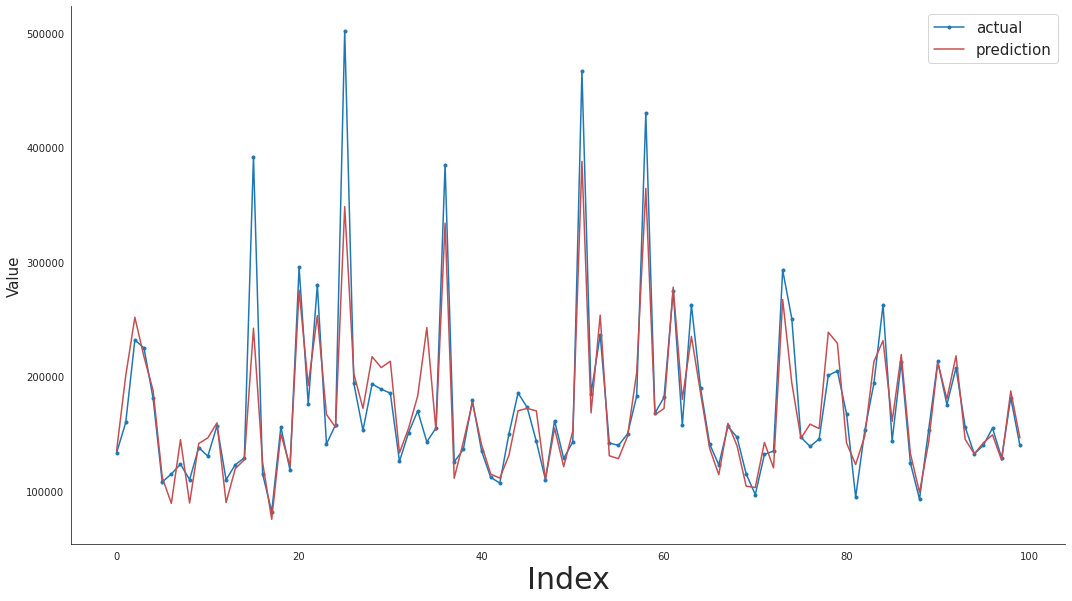

In [36]:
plotPresVsActual(val_df,glr_preds)

# RandomForest Tree Regression

In [37]:
dtr = RandomForestRegressor(featuresCol='features', labelCol='SalePrice', predictionCol='prediction',maxDepth=30,numTrees=50,maxBins=3000)
dtr_model = dtr.fit(train_df)

dtr_predictions = dtr_model.transform(val_df)
dtr_preds = dtr_predictions.toPandas()['prediction']
dtr_predictions.select("prediction","SalePrice","features").show(5)
dtr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="rmse")
print("R Squared (R2) on test data = %g" % dtr_evaluator.evaluate(dtr_predictions))


+----------+---------+--------------------+
|prediction|SalePrice|            features|
+----------+---------+--------------------+
| 128461.66|   133500|(82,[0,1,2,3,4,5,...|
| 182297.74|   159895|(82,[0,1,2,3,4,5,...|
| 260221.62|   232000|(82,[0,1,2,3,4,5,...|
|  221081.4|   224900|(82,[0,1,2,3,4,5,...|
| 183766.64|   181000|(82,[0,1,2,3,4,5,...|
+----------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 36984.8


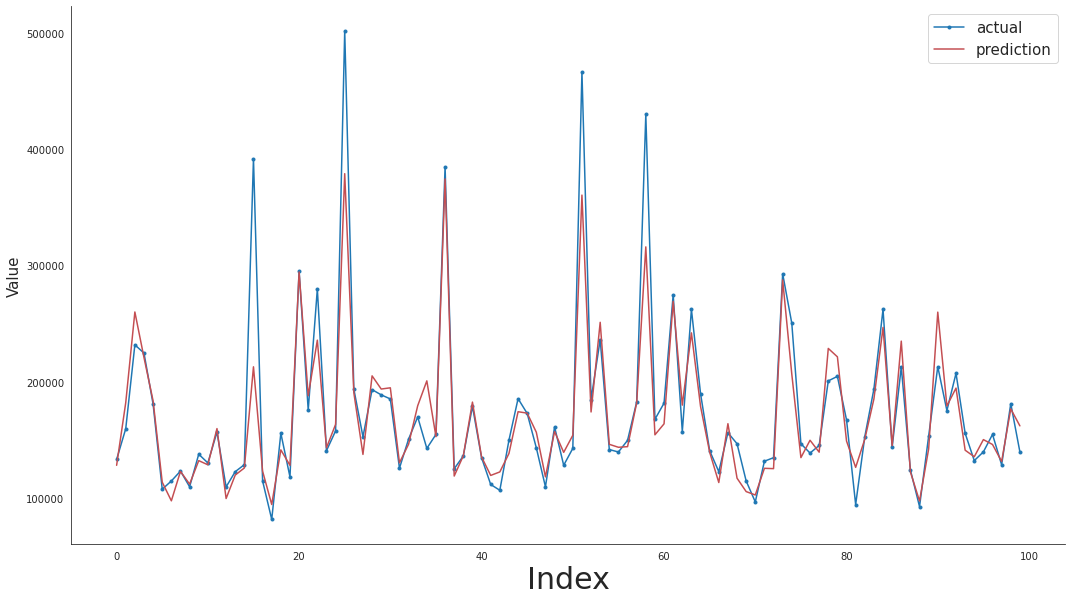

In [38]:
plotPresVsActual(val_df,dtr_preds)

# LinearRegression Model 

In [39]:
lr = LinearRegression(featuresCol = 'features', labelCol='SalePrice', maxIter=10000, regParam=0.8,elasticNetParam=1)
lr_model = lr.fit(train_df)

lr_predictions = lr_model.transform(val_df)
preds = lr_predictions.toPandas()['prediction']
lr_predictions.select("prediction","SalePrice","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="rmse")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))



+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 135417.7075445876|   133500|(82,[0,1,2,3,4,5,...|
|201749.73468934876|   159895|(82,[0,1,2,3,4,5,...|
|245375.67998678537|   232000|(82,[0,1,2,3,4,5,...|
|211407.29656962113|   224900|(82,[0,1,2,3,4,5,...|
| 181175.4758391136|   181000|(82,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 52823.7


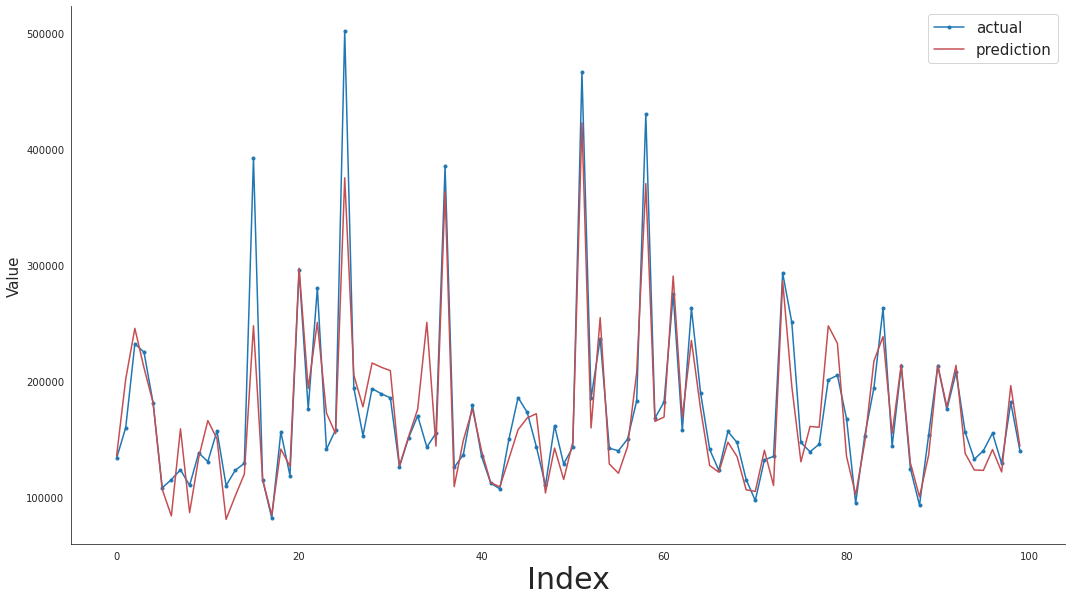

In [40]:
plotPresVsActual(val_df,preds)

# GBTRegressor

In [41]:
gbt = GBTRegressor(featuresCol = 'features', labelCol='SalePrice',maxDepth=20,lossType='squared',maxIter=100)
gbt_model = gbt.fit(train_df)

gbt_predictions = gbt_model.transform(val_df)
preds = gbt_predictions.toPandas()['prediction']
gbt_predictions.select("prediction","SalePrice","features").show(5)
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="rmse")
print("R Squared (R2) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))



+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|119499.99999999983|   133500|(82,[0,1,2,3,4,5,...|
|213490.00000000017|   159895|(82,[0,1,2,3,4,5,...|
|248899.99999999977|   232000|(82,[0,1,2,3,4,5,...|
|          240000.0|   224900|(82,[0,1,2,3,4,5,...|
| 207500.0000000002|   181000|(82,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 52803.3


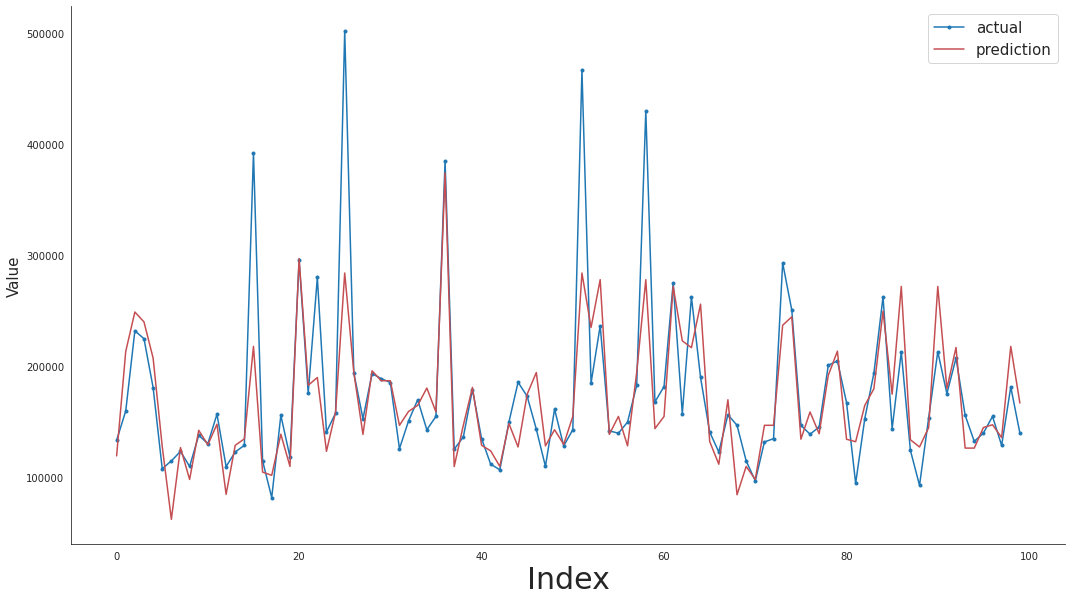

In [42]:
plotPresVsActual(val_df,preds)

# Decision Tree Regressor

In [43]:
dcr2 = DecisionTreeRegressor(featuresCol = 'features', labelCol='SalePrice',maxDepth=30,maxBins=300000,minInstancesPerNode=37)
dcr2_model = dcr2.fit(train_df)

dcr2_predictions = dcr2_model.transform(val_df)
preds = dcr2_predictions.toPandas()['prediction']
dcr2_predictions.select("prediction","SalePrice","features").show(5)
dcr2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="rmse")
print("R Squared (R2) on test data = %g" % dcr2_evaluator.evaluate(dcr2_predictions))



+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|138457.53968253967|   133500|(82,[0,1,2,3,4,5,...|
|186058.62790697673|   159895|(82,[0,1,2,3,4,5,...|
| 262737.8461538461|   232000|(82,[0,1,2,3,4,5,...|
|249152.76388888888|   224900|(82,[0,1,2,3,4,5,...|
|186058.62790697673|   181000|(82,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 44594.6


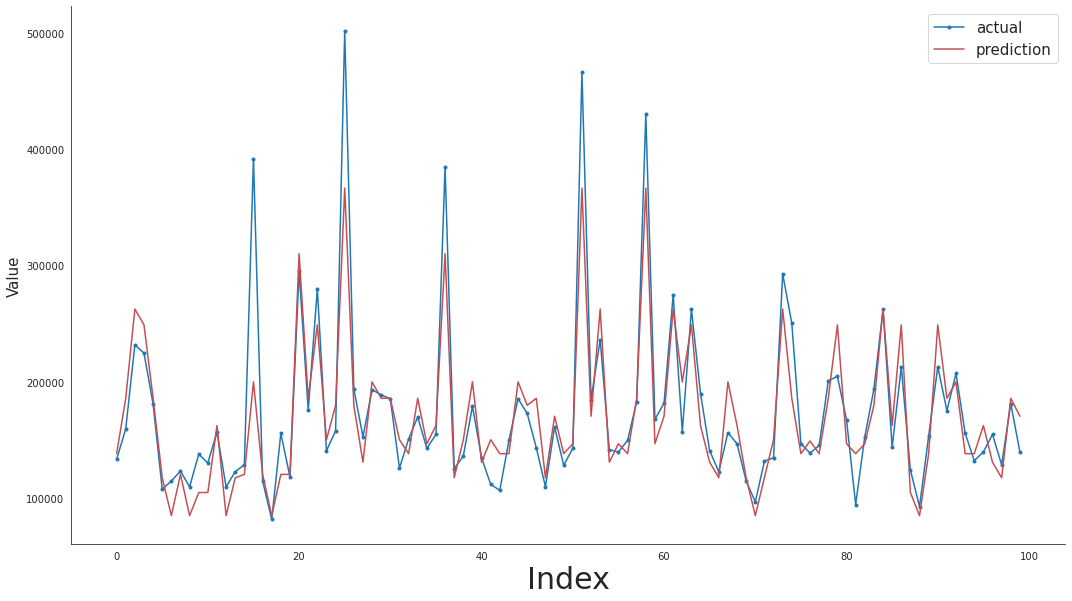

In [44]:
plotPresVsActual(val_df,preds)

# Spark File Streaming and Producer

In [45]:
p = Producer({'bootstrap.servers': 'localhost:9092'})

In [46]:
TOPIC = 'finalproject_topic'
ssc = StreamingContext(sc, 2)
FILE_PATH = '/home/linuxu/DStreamFolder' # every csv file - every row should be in new line. else throwing errors.

In [47]:
test_schema= spark.read.option("header",True).option("inferschema", "true").csv('/home/linuxu/FinalProject/test.csv').schema


In [48]:
def process_dataframe(df):
    for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',):
        df = df.withColumn(col, regexp_replace(col, 'NA', 'None'))
    for col in ('BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
        df = df.withColumn(col, regexp_replace(col, 'NA', 'None'))
        
    df = df.withColumn('MasVnrType', regexp_replace('MasVnrType', 'NA', 'None'))
    df = df.withColumn('MasVnrArea', regexp_replace('MasVnrArea', 'NA', '0'))
    
    for col in ['Exterior1st','Exterior2nd','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','SaleType','MSZoning','Electrical']:
        df = fill_na_random_pick_column_distribution(df, col)

    df = df.withColumn("LotFrontage", df['LotFrontage'].cast('double'))
    imputer = Imputer(inputCols=['LotFrontage'],outputCols=['LotFrontage']).setStrategy("median")
    df = imputer.fit(df).transform(df)
    
    for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']:
        df = df.withColumn(col, regexp_replace(col, 'NA', 'None'))
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','TotalBsmtSF'):
        df = df.withColumn(col, regexp_replace(col, 'NA', '0'))
    df_id = df.select('id')
    df = df.drop('Utilities','Street','Id')
    df = df.withColumn('TotalSF',df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])

    df = df.withColumn('Total_Bathrooms',df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df = df.withColumn('hasPool',when(df['PoolArea'] > 0 ,1).otherwise(0))
    df = df.withColumn('hasGarage',when(df['GarageArea'] > 0 ,1).otherwise(0))
    df = df.withColumn('hasBsmt',when(df['TotalBsmtSF'] > 0 ,1).otherwise(0))
    X = categorical_encode(df)
    X = assemble(X,False)
    X = scale.transform(X)
    return df_id,X

In [49]:
def process_stream(record, t_schema):
    if not record.isEmpty():
        print('New RDD..')
        record = record.map(lambda x : x.split(',')) # split into array every line
        record = record.map(lambda x : [int(y) if y.isnumeric() else y for y in x]) # cast to integer by schema.

        df = spark.createDataFrame(record,schema=t_schema) 
        df_id, df = process_dataframe(df)
        predictions = dtr_model.transform(df)
        results = predictions.select('prediction').toPandas()
        ids = [x[0] for x in df_id.collect()]
        results['id'] = ids
        p.produce(TOPIC, value=results.to_json(orient='index'))


In [50]:
dstream = ssc.textFileStream(FILE_PATH)
dstream.foreachRDD(lambda rdd: process_stream(rdd, test_schema))

In [51]:
ssc.start() 
ssc.awaitTermination()


New RDD..
New RDD..
New RDD..
New RDD..


KeyboardInterrupt: 